# 3、求数据的前 n 个主成分

## 如何求解数据的前 $k$ 个主成分
同样，下面的表述同样不准确，但是能够帮助我回忆起这部分学习的重点和思路

1、第 1 主成分是那个最重要的维度；

2、将原数据减去第 1 个主成分，然后，再求第 1 主成分，就是原数据的第 2 主成分，依次类推，就可以得到前 $k$ 个主成分。

难点：理解什么叫做，将数据在第 1 个主成分上的分量去掉，即是做向量的减法，因为之前方差最大化的时候，使用了投影的概念，因此做向量减法的时候，剩下的那个分量一定是与被减去的主成分垂直的。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = np.empty((100, 2))
X[:, 0] = np.random.uniform(0., 100., size=100)
X[:, 1] = 0.75 * X[:, 0] + 3. + np.random.normal(0, 10., size=100)

In [2]:
def demean(X):
    return X - np.mean(X, axis=0)


X = demean(X)

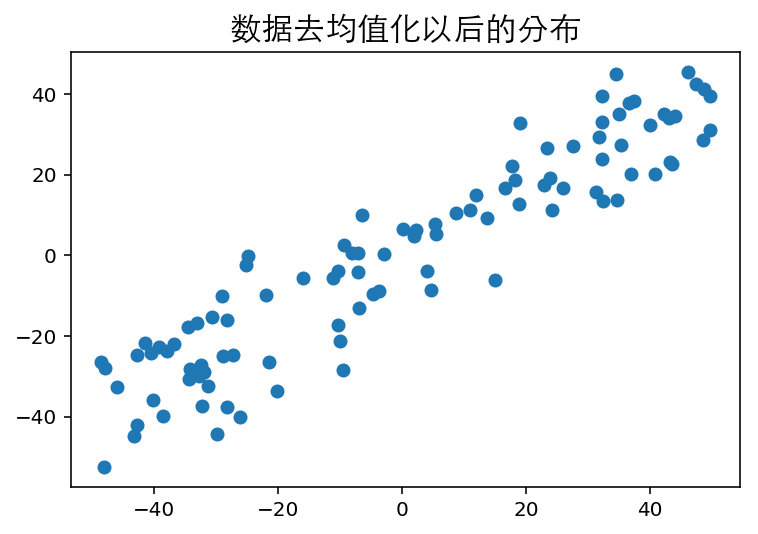

In [4]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname='/System/Library/Fonts/STHeiti Light.ttc', size=16)


plt.scatter(X[:, 0], X[:, 1])
plt.title('数据去均值化以后的分布',fontproperties=font)
plt.show()

此时画出的图的中心在原点。

In [5]:
# 目标函数
def f(w, X):
    return np.sum((X.dot(w)**2)) / len(X)

# 目标函数的梯度


def df(w, X):
    return X.T.dot(X.dot(w)) * 2. / len(X)

# 向量单位化
def direction(w):
    return w / np.linalg.norm(w)

# 求解第 1 主成分
def first_component(X, initial_w, eta, n_iters=1e4, epsilon=1e-8):
    w = direction(initial_w)
    cur_iter = 0
    while cur_iter < n_iters:
        gradient = df(w, X)
        last_w = w
        w = w + eta * gradient
        w = direction(w)
        if(abs(f(w, X) - f(last_w, X)) < epsilon):
            break
        cur_iter += 1
    return w

In [6]:
initial_w = np.random.random(X.shape[1])
eta = 0.01
w = first_component(X, initial_w, eta)
w

array([ 0.75249572,  0.65859714])

这一步不好理解。
使用的公式是：

$$
X'^{(i)} = X^{(i)} - X^{(i)}_{project}
$$

其中
$$
X^{(i)}_{project} = ||X^{(i)}_{project}|| \cdot w
$$

而 

$$
||X^{(i)}_{project}|| = X^{(i)} \cdot w
$$
$w$ 是上一个主成分分析求出的单位向量。

In [7]:
X2 = np.empty(X.shape)
for i in range(len(X)):
    # 对原来的数据的每一行（即每一个样本）做这样的处理。
    # 这里的 w 经过主成分分析以后，就是一个单位向量
    X2[i] = X[i] - X[i].dot(w) * w

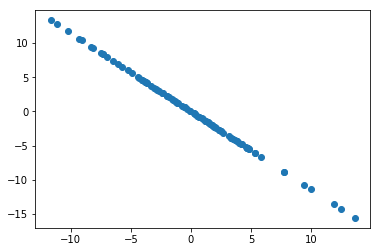

In [8]:
plt.scatter(X2[:, 0], X2[:, 1])
plt.title('去掉了第 1 主成分分量以后的的数据分布')
plt.show()

In [9]:
w2 = first_component(X2, initial_w, eta)
w2

array([-0.65859436,  0.75249816])

In [10]:
w.dot(w2)

3.696988775170329e-06

可以一步到位，使用向量化的操作。

In [11]:
X2 = X - X.dot(w).reshape(-1, 1) * w

于是，按照最开始求解前 $k$ 个主成分（下面的函数定义主成分的个数的符号是 $n$）的函数可以写成：

In [12]:
def first_n_component(n, X, eta=0.01, n_iters=1e4, epsilon=1e-8):
    # 原始特征矩阵的值会被修改，所以做一次深层拷贝
    X_pca = X.copy()
    X_pca = demean(X_pca)
    res = []

    for i in range(n):
        initial_w = np.random.random(X_pca.shape[1])
        w = first_component(X_pca, initial_w, eta)
        res.append(w)
        # 【重点理解这一步】：依次去掉第 1 主成分分量，第 2 主成分分量
        X_pca = X_pca - X_pca.dot(w).reshape(-1, 1) * w

    return res

重点来了：我们看看主成分到底长什么样子。

+ 主成分是一个矩阵，矩阵的行数就表示几个主成分，可以这样理解，第 1 行，即第 1 主成分，是那个最重要的维度，第 2 行，第 2 主成分次之，以此类推
+ 每 1 个主成分仍然有 n 个特征，并且每一个主成分都是单位向量
+ 那么如何实现降维呢？公式是：

$$
X \cdot w_k^{T} 
$$

这里， $X$ 的 shape 是 $m \times n$，$w_k^{T} $ 的 shape 是 $n \times k$，它们相乘以后得到的矩阵的 shape 就是 $m \times k$，就是通过矩阵的相乘来降维的，可以理解为通过矩阵的乘法，将数据从一个高维坐标系移到了一个低维度的坐标系。

In [13]:
first_n_component(2, X)

[array([ 0.75249581,  0.65859704]), array([ 0.65860167, -0.75249176])]

In [14]:
first_n_component = first_n_component(2, X)

In [15]:
first_n_component[0].dot(first_n_component[1])

5.4819137101924653e-06

因为只有两个主成分，这两个主成分向量应该是垂直的，这个现象在线性代数中即是正交。